In [1]:
import networkx as nx
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np
import math
from bisect import bisect

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 7.0]
mpl.rcParams['figure.dpi'] = 100

In [3]:
from lib.utils.data_spit import data_split

from lib.generators.LFR import LFR
from lib.generators.OLP import OLP

In [4]:
# hyperparameters

seed = random.randint(1, 1000)                              # random seed

# CLASSIFIER PARAMETERS
quality_class_intervals = [0, 0.25, 0.50, 0.75, 1.001]      # quality class intervals
quality_class_labels = [0, 1, 2, 3]                         # quality class labels
quality_class_names = ['exelent', 'good', 'ok', 'poor']     # quality classes names

# Step 1
## Graph and features generation

Generate/import graph and features based on avalible `generator` classes

In [5]:
generator = LFR(n=1000, t1=3, t2=1.5, m=0.1, seed=seed)
#generator = OLP(network_index=0)

ground_truth_df = generator.get_df()

features_df = generator.get_features_df()
feature_names = generator.feature_names

feature_names

['RAI', 'JC', 'AAI', 'PA']

In [6]:
ground_truth_df['goal'].value_counts()

1    5041
0    5041
Name: goal, dtype: int64

In [7]:
features_df.head(5)

,node1,node2,RAI,JC,AAI,PA
1210666,248,2874,0.0,0.0,0.0,0.011842
7516734,1845,2625,0.0,0.0,0.0,0.018421
9825359,2691,3085,0.0,0.0,0.0,0.015789
9497352,2553,2748,0.0,0.0,0.0,0.015789
8339716,2118,2607,0.0,0.0,0.0,0.009868


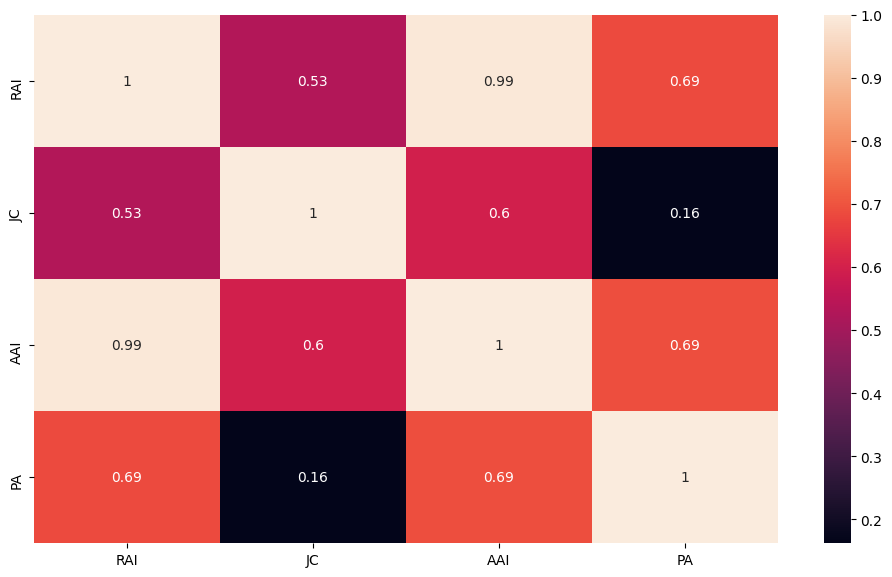

In [8]:
corrMatrix = features_df[feature_names].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# Step 2
## Splitting the data

We split the data in the following way:
* 1/3 is used to train a link prediction model
* 1/3 is used to test the link prediction model. Here we also calculate the error and use this data to train quality classifier
* 1/3 is used to evaluate the clasifier

In [9]:
link_prediction_train, link_prediction_test, classifier_test = data_split(ground_truth_df, features_df)

In [10]:
link_prediction_train['goal'].value_counts()

1    1678
0    1678
Name: goal, dtype: int64

In [11]:
link_prediction_test['goal'].value_counts()

1    1678
0    1678
Name: goal, dtype: int64

In [12]:
classifier_test['goal'].value_counts()

1    1678
0    1678
Name: goal, dtype: int64

# Step 3
## Link prediction model

Predict links using one of the avalble link prediction models

In [13]:
from lib.link_prediction_models.RandomForestOnFeatures import RandomForestOnFeatures

model = RandomForestOnFeatures(X_train=link_prediction_train[feature_names], Y_train=link_prediction_train['goal'], random_state=seed)

prob = model.predict_proba(link_prediction_test[feature_names])
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob
0,2822,4365,0,0.0,0.0,0.0,0.015789,0.338851
1,1182,4972,0,0.0,0.0,0.0,0.003947,0.340816
2,2791,4261,0,0.0,0.0,0.0,0.030263,0.228268
3,1112,4778,0,0.0,0.0,0.0,0.064474,0.415430
4,846,3775,0,0.0,0.0,0.0,0.003947,0.158831


In [14]:
print(f'Accuracy score on {len(link_prediction_test)} test samples:')
print(model.accuracy_score(link_prediction_test[feature_names], link_prediction_test['goal']))

Accuracy score on 3356 test samples:
0.6758045292014303


# Step 4
## Quality class analisys

In [15]:
from bisect import bisect

def quality_class_label(error): 
    return bisect(quality_class_intervals, error) - 1

In [16]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba['quality_label'] = link_proba.apply(lambda row: quality_class_label(row['abs_error']), axis=1)
link_proba['quality_name'] = link_proba.apply(lambda row: quality_class_names[quality_class_label(row['abs_error'])], axis=1)
link_proba.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob,abs_error,quality_label,quality_name
0,2822,4365,0,0.0,0.0,0.0,0.015789,0.338851,0.338851,1,good
1,1182,4972,0,0.0,0.0,0.0,0.003947,0.340816,0.340816,1,good
2,2791,4261,0,0.0,0.0,0.0,0.030263,0.228268,0.228268,0,exelent
3,1112,4778,0,0.0,0.0,0.0,0.064474,0.415430,0.415430,1,good
4,846,3775,0,0.0,0.0,0.0,0.003947,0.158831,0.158831,0,exelent


In [17]:
# statistics on error
link_proba['abs_error'].describe()

count    3356.000000
mean        0.384621
std         0.225311
min         0.000000
25%         0.228268
50%         0.376430
75%         0.580236
max         1.000000
Name: abs_error, dtype: float64

Text(0, 0.5, 'Number of node pairs')

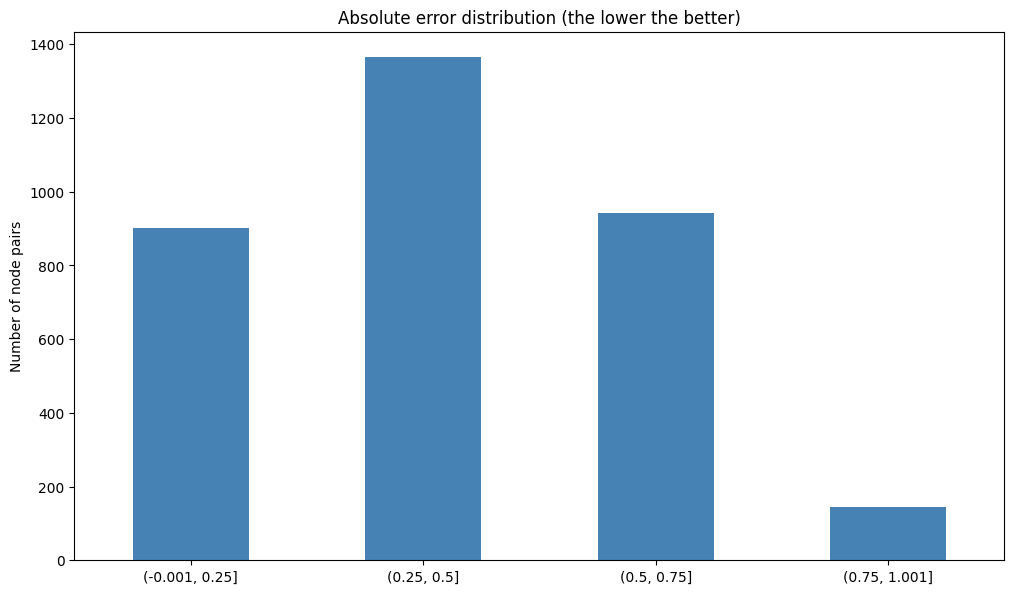

In [18]:
# plot error distribution
fig, ax = plt.subplots()

pd.cut(link_proba['abs_error'], bins=quality_class_intervals, include_lowest=True).value_counts(sort=False).plot.bar(rot=0, color='steelblue', ax=ax)
ax.set_title("Absolute error distribution (the lower the better)")
ax.set_ylabel("Number of node pairs")

# Step 5
## Quality class prediction

In [19]:
# train for quality class prediction
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

#clf = LogisticRegression(random_state=seed)  #clf = LogisticRegression(random_state=seed, class_weight='balanced')
#clf = clf = DecisionTreeClassifier(random_state=seed)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=seed)

clf.fit(link_proba[feature_names], link_proba['quality_label'])

GradientBoostingClassifier(learning_rate=1.0, max_depth=2, random_state=931)

In [20]:
# testing the classifier

pred = clf.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = clf.predict_proba(classifier_test[feature_names])[:, 1]
proba = pd.Series(proba, name='prob')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: quality_class_label(row['true_abs_error']), axis=1)
classifier_test.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob,predicted_quality_label,true_abs_error,true_quality_label
0,4286,4772,0,0.0,0.0,0.0,0.018421,0.395049,1,0.395049,1
1,2065,2254,0,0.0,0.0,0.0,0.015789,0.508524,1,0.508524,2
2,1408,3413,0,0.0,0.0,0.0,0.005921,0.456372,1,0.456372,1
3,1385,4824,0,0.0,0.0,0.0,0.015789,0.508524,1,0.508524,2
4,1099,3212,0,0.0,0.0,0.0,0.003947,0.587418,1,0.587418,2


In [21]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
2                     1426
1                     1388
3                      489
0                       53
dtype: int64

In [22]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          2547
2                           520
0                           254
3                            35
dtype: int64

In [23]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])
scores_df['Score'] = pd.Series([
    len(classifier_test),
    clf.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,3356.000000
1,Accuracy,0.436234
2,Precision,0.445766
3,Recall,0.436234
4,F1 score,0.349584


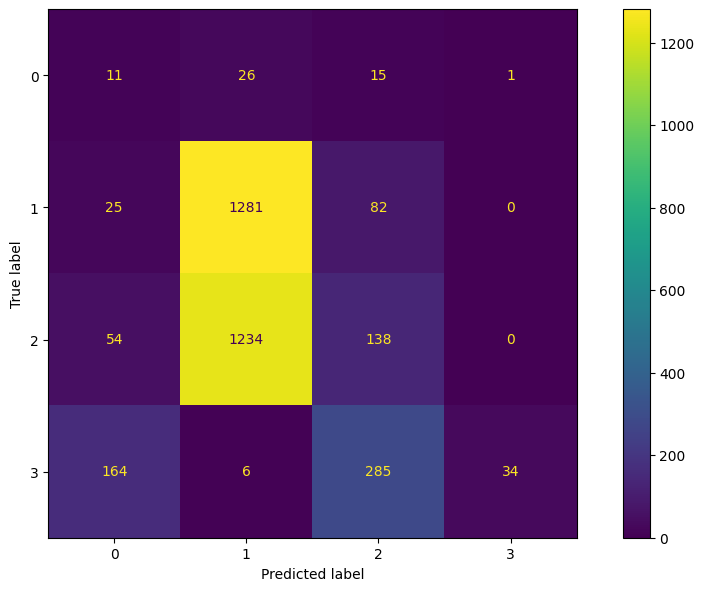

In [24]:
metrics.plot_confusion_matrix(clf, classifier_test[feature_names], classifier_test['true_quality_label'])